<a href="https://colab.research.google.com/github/maggie-scale/Group-9C-Capstone-1/blob/main/Sem-Eval%202010%20Task8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Group 9C SGUS NUS Capstone Project 2022 
### Improve Demand Forecasting through Natural Language Processing for Panasonic

The objective of the project is to develop a technology to detect cause-effect relationship from news corpora using Lexicon based relation identification

Methodology: 
1.   Data Preparation
2.   Model Training
3. Model Optimisation
4. Model Evaluation


## Step 1: Data preparation

#### Data set suggested by Panasonic for this exercise is from https://www.kaggle.com/datasets/drtoshi/semeval2010-task-8-dataset

Data set comes with predefined labels e1 and e2, not limited to just cause-effect

Python libraries used

Panda - Data analysis manipulation library for Python

Numpy - Mathematical operations over arrays

In [ ]:


import pandas as pd        #data analysis and manipulation library for Python
import numpy as np         #mathematical operations over arrays

#Global variables
train_data = []            #sentence for training with labels 
train_target = []          #labels for training data
test_data = []             #sentence for testing with labels  
test_target = []           #labels for testing data

#### Create data frames

In [ ]:
#Import files into a dataframe
def import_text(file_txt):
    
    colnames=['ID', 'Text'] 
    
    df = pd.read_csv(file_txt
                       ,skip_blank_lines=True   #input files have emplty lines
                       ,header=None             #no haeders
                       ,sep='\t'                #tab delimited
                       ,engine='python'         #engine
                       ,quotechar='^'           #if there are doublequotes in the text
                       ,comment='Comment:'      #this is for human reader, we don't need
                       ,names=colnames          #preset columns we need
                      )
    print("Number of rows: ", len(df.index))

    return df

In [ ]:
#clean ""
def clean_doublequotes(df):
    return df.replace('"', '', regex=True)

In [ ]:
#clean tags e.g. (e2,e1) - to check why?
def clean_tags(df_column,braket_type):
    
    if braket_type == 'angle':
        pattern = r'<.*?>'
    elif braket_type == 'round':
        pattern = r'(\(.*?\))'
    else:
        raise Exception("angle or round")
    
    return df_column.str.replace(pattern, '', regex=True)

In [ ]:
#create tuple of keys
keys = ('Other','Cause-Effect','Product-Producer','Entity-Origin','Instrument-Agency','Component-Whole','Content-Container','Entity-Destination','Member-Collection','Message-Topic')
#for i in range(len(keys)): print(i, keys[i])

In [ ]:
def prepare_file(file_name,use):
    
    #Import training file into a dataframe
    df = import_text(file_name)

    #clean ""
    df = clean_doublequotes(df)

    # combine rows 1&2
    df['Clasification'] = df['ID'].shift(-1)

    #remove leftover rows
    df = df[df.Text.notna()]

    #clean tags e.g. <e2> - better option would be to keep them and use for more precise prediction
    df.Text = clean_tags(df.Text,braket_type='angle')

    #clean tags e.g. (e2,e1) - better option would be to keep them and use for more precise prediction
    df.Clasification = clean_tags(df.Clasification,braket_type='round')

    #Map Keys to numbers
    df['Clasification_ID'] = df.Clasification.map(lambda x: keys.index(x))

    #to use in thes same file
    if use == 'train':
        global train_data
        train_data = df.Text
        
        global train_target
        train_target = df.Clasification_ID
    elif use == 'test':
        global test_data
        test_data = df.Text
        
        global test_target
        test_target = df.Clasification_ID

    #check
    print('Output rows:', len(df.index))
  
    return df

#### Prepare Training file

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/Github/Group-9C-Capstone

/content/drive/MyDrive/Github/Group-9C-Capstone


In [ ]:
#prepare file
df_train = prepare_file('semeval2010task8_train.txt','train')

df_train.head(5)

Number of rows:  16000
Output rows: 8000


,ID,Text,Clasification,Clasification_ID
0,1,The system as described above has its greatest...,Component-Whole,5
2,2,The child was carefully wrapped and bound into...,Other,0
4,3,The author of a keygen uses a disassembler to ...,Instrument-Agency,4
6,4,A misty ridge uprises from the surge.,Other,0
8,5,The student association is the voice of the un...,Member-Collection,8


In [ ]:
df_test = prepare_file('semeval2010task8_test.txt','test')

df_test.head(5)

Number of rows:  5434
Output rows: 2717


,ID,Text,Clasification,Clasification_ID
0,8001,The most common audits were about waste and re...,Message-Topic,9
2,8002,The company fabricates plastic chairs.,Product-Producer,2
4,8003,The school master teaches the lesson with a st...,Instrument-Agency,4
6,8004,The suspect dumped the dead body into a local ...,Entity-Destination,7
8,8005,Avian influenza is an infectious disease of bi...,Cause-Effect,1


##Step 2: Data Visualisation


To explore data and find out the frequency count of each classification for both Train and Test datasets. The shape of Test data is quite similar to that of the Train data. In the Training dataset, each classification ID has sufficient records for training (minimum being ID=4 with approximately 500 records).

**Stratified Train-Test Splits**: 
Some classification problems do not have a balanced number of examples for each class label. As such, it is desirable to split the dataset into train and test sets in a way that preserves the same proportions of examples in each class as observed in the original dataset.

In [ ]:
import matplotlib.pyplot as plt                                #interactive plots 

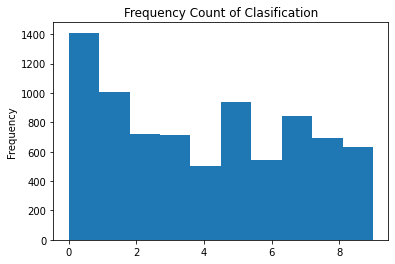

In [ ]:
df_train.Clasification_ID.plot.hist(bins=10, title='Frequency Count of Clasification')

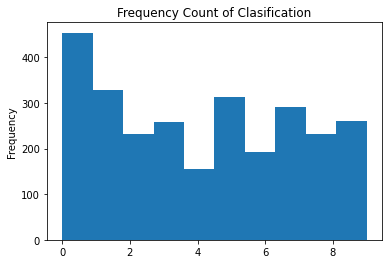

In [ ]:
df_test.Clasification_ID.plot.hist(bins=10, title='Frequency Count of Clasification')

##Step 3: Top n Words

Two Stop Word Lists are used. One is custom made and the other is from NLTK corpus to compare which Stop Word List performs better at removing redundant, common words that are not meaningful to the analysis.

In [ ]:
# Create own stop word list
mystopwd_list = ["a", "about", "after", "all", "also", "always", "am", "an", "and", "any", "are", "at", "be", "been", "being", "but", "by", "came", "can", "cant", "come", "could", "did", "didn't", "do", "does", "doesn't", "doing", "don't", "else", "for", "from", "get", "give", "goes", "going", "had", "happen", "has", "have", "having", "how", "i", "if", "ill", "i'm", "in", "into", "is", "isn't", "it", "its", "i've", "just", "keep", "let", "like", "made", "make", "many", "may", "me", "mean", "more", "most", "much", "no", "not", "now", "of", "only", "or", "our", "really", "say", "see", "some", "something", "take", "tell", "than", "that", "the", "their", "them", "then", "they", "thing", "this", "to", "try", "up", "us", "use", "used", "uses", "very", "want", "was", "way", "we", "what", "when", "where", "which", "who", "why", "will", "with", "without", "wont", "you", "your", "youre"]
mystopwd_list[:10]

['a', 'about', 'after', 'all', 'also', 'always', 'am', 'an', 'and', 'any']

In [ ]:
import nltk
# nltk.download('stopwords')
from nltk.corpus import stopwords
nltk_stopword = list(stopwords.words('english'))
nltk_stopword[:10]

LookupError: ignored

In [ ]:
from collections import Counter

In [ ]:
def top20wd(df, num, stopwords, n):
  
  # Split the Text column into words to a list
  df_fText = df.loc[df.Clasification_ID==num]['Text'].str.split() 

  # Filter out stop words- either run mystopwd_list or nltk_stopword
  df_fText = df_fText.apply(lambda x: [i for i in x if i.lower() not in stopwords])

  word_list = df_fText.sum()

  return Counter(word_list).most_common()[:n]

In [ ]:
top20wd(df_train, 0, nltk_stopword, 21)

In [ ]:
top20wd(df_train, 1, nltk_stopword, 20)

In [ ]:
top20wd(df_train, 2, nltk_stopword, 21)

## Step 4: training models

In [ ]:
# use the TF-IDF vectorizer and create a pipeline that attaches it to a multinomial naive Bayes classifier
from sklearn.feature_extraction.text import TfidfVectorizer    #Convert a collection of raw documents to a matrix of TF-IDF features
from sklearn.naive_bayes import MultinomialNB                  #multinomial Naive Bayes classifier is suitable for classification with discrete features
from sklearn.pipeline import make_pipeline                     #Construct a Pipeline from the given estimators

#show data
import seaborn as sns; sns.set()                               #data visualization library based on matplotlib
import matplotlib.pyplot as plt                                #interactive plots 
from sklearn.metrics import confusion_matrix                   #Compute confusion matrix to evaluate the accuracy of a classification

### Train model 1: Multinomial Naive Bayes (standard parameters)

In [ ]:
model = make_pipeline(TfidfVectorizer(), MultinomialNB())

In [ ]:
#TO READ: https://jakevdp.github.io/PythonDataScienceHandbook/05.04-feature-engineering.html

In [ ]:
#With this pipeline, we can apply the model to the training data, and predict labels for the test data
model.fit(train_data, train_target)
labels = model.predict(test_data)

In [ ]:
#evaluate the performance of the estimator with confusion matrix between the true and predicted labels for the test data
plt.rcParams['font.size'] = '26'
mat = confusion_matrix(test_target, labels)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, xticklabels=keys, yticklabels=keys)

plt.xlabel('true label')
plt.ylabel('predicted label')

from matplotlib.pyplot import figure
figure(figsize=(6, 6), dpi=800)

In [ ]:
accuracy_for_test_keys = np.mean(labels == test_target)
print("Multinomial Naive Bayes Model Accuracy = {} %".format(accuracy_for_test_keys*100))

In [ ]:
def predict_category(s, train=keys, model=model):
    pred = model.predict([s])
    return train[pred[0]]

In [ ]:
df_test['Calculated_Clasification_ID'] = labels

In [ ]:
df_test['Calculated_Clasification'] = df_test.Calculated_Clasification_ID.map(lambda x: keys[x])

In [ ]:
df_test.head(10)

### Train model 2: Multinomial Naive Bayes (optimized parameters)

In [ ]:
#https://holypython.com/nbc/naive-bayes-classifier-optimization-parameters/

#https://www.geeksforgeeks.org/using-countvectorizer-to-extracting-features-from-text/
#model1 = make_pipeline(CountVectorizer(ngram_range=(1,3)), TfidfVectorizer(), MultinomialNB())

In [ ]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer


In [ ]:
#Tokenizing text with scikit-learn we used CountVectorizer
count_vector = CountVectorizer()
train_counts = count_vector.fit_transform(train_data)

# Term Frequencies are calculated which has to be use_idf=True 
tf_transformer = TfidfTransformer(use_idf=True).fit(train_counts)
tf_train = tf_transformer.transform(train_counts)

#Term Frequency times Inverse Document Frequency to skipping redundant processing
tf_idf_transformer = TfidfTransformer()
tf_idf_train = tf_idf_transformer.fit_transform(train_counts)

#Training a classifier 
# Now we took Naive Bayes classifier which provides a nice baseline for this task
# We used the Multinomial Naive Bayes
#print (tf_idf_train)
#print (train_target)
multi_nb = MultinomialNB().fit(tf_idf_train, train_target)

# Combing the all CountVectorizer,TfidfTransformer,MultinomialNB with alpha value 0.01
#ngram_range The lower and upper boundary of the range of n-values is 1 and 3
text_classification = Pipeline([('vectorizer', CountVectorizer(ngram_range=(1,3))),
    ('tfidftransformer', TfidfTransformer(use_idf=True)),
    ('classification', MultinomialNB(alpha=0.01)),])
text_classification = text_classification.fit(train_data, train_target)
predicted = text_classification.predict(test_data)

# Naive Bayes predicted values is saving to csv file
np.savetxt("naive_bayes_predicted.csv", predicted, delimiter=",")

accuracy_for_test_keys = np.mean(predicted == test_target)
print("Multinomial Naive Bayes Model Accuracy = {} %".format(accuracy_for_test_keys*100))

In [ ]:
plt.rcParams['font.size'] = '12'
mat = confusion_matrix(test_target, predicted)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, xticklabels=keys, yticklabels=keys)

plt.xlabel('true label')
plt.ylabel('predicted label')

from matplotlib.pyplot import figure
figure(figsize=(10, 10), dpi=800)

### Train model 3: Support Vector Machine BASIC

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
#Reference: https://gist.github.com/dspp779/5a9597e2d8a2518b80fb0ad191ea8463

In [ ]:
#Build a vectorizer / classifier pipeline that filters out tokens that are too rare or too frequent
text_clf = Pipeline([('vect', TfidfVectorizer()),
                     ('clf', SVC()),
])

In [ ]:
text_clf.fit(train_data, train_target)

In [ ]:
y_predicted = text_clf.predict(test_data)

In [ ]:
accuracy_for_test_keys = np.mean(y_predicted == test_target)
print("SVM Model Accuracy = {} %".format(accuracy_for_test_keys*100))

In [ ]:
from sklearn import metrics
print(metrics.classification_report(test_target, y_predicted, target_names=keys))
#Precision is the fraction of positive class predictions that actually belong to the positive class. 
#Recall is the fraction of positive class predictions made out of all positive examples in the dataset. 
#F1-score combines the precision and recall of a classifier into a single metric by taking their harmonic mean. 
#Higher F1 scores are generally better.

In [ ]:
#evaluate the performance of the estimator with confusion matrix between the true and predicted labels for the test data
plt.rcParams['font.size'] = '12'
mat = confusion_matrix(test_target, y_predicted)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, xticklabels=keys, yticklabels=keys)

plt.xlabel('true label')
plt.ylabel('predicted label')

from matplotlib.pyplot import figure
figure(figsize=(9, 9), dpi=800)

### Train model 4: Support Vector Machine Linear Kernel

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
#Reference: https://gist.github.com/dspp779/5a9597e2d8a2518b80fb0ad191ea8463

In [ ]:
#Build a vectorizer / classifier pipeline that filters out tokens that are too rare or too frequent
text_clf = Pipeline([('vect', TfidfVectorizer()),
                     ('clf', LinearSVC()),
])

In [ ]:
text_clf.fit(train_data, train_target)

In [ ]:
y_predicted = text_clf.predict(test_data)

In [ ]:
accuracy_for_test_keys = np.mean(y_predicted == test_target)
print("SVM Model Accuracy = {} %".format(accuracy_for_test_keys*100))

In [ ]:
from sklearn import metrics
print(metrics.classification_report(test_target, y_predicted, target_names=keys))
#Precision is the fraction of positive class predictions that actually belong to the positive class. 
#Recall is the fraction of positive class predictions made out of all positive examples in the dataset. 
#F1-score combines the precision and recall of a classifier into a single metric by taking their harmonic mean. 
#Higher F1 scores are generally better.

In [ ]:
#evaluate the performance of the estimator with confusion matrix between the true and predicted labels for the test data
plt.rcParams['font.size'] = '12'
mat = confusion_matrix(test_target, y_predicted)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, xticklabels=keys, yticklabels=keys)

plt.xlabel('true label')
plt.ylabel('predicted label')

from matplotlib.pyplot import figure
figure(figsize=(9, 9), dpi=800)

### Train model 5: Support Vector Machine Linear Kernel with Gridsearch (2/3-gram)

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.model_selection import GridSearchCV
#Reference: https://gist.github.com/dspp779/5a9597e2d8a2518b80fb0ad191ea8463

In [ ]:
#Build a vectorizer / classifier pipeline that filters out tokens that are too rare or too frequent
pipeline = Pipeline([
    ('vect', TfidfVectorizer()),
    ('clf', LinearSVC()),
])

In [ ]:
#Build a grid search to find out whether 2-grams or 3-grams are more useful. 
#Fit the pipeline on the training set using grid search for the parameters
parameters = {
    'vect__ngram_range': [(1, 2), (1, 3)],
}
grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1)
grid_search.fit(train_data, train_target)

In [ ]:
#Print the mean and std for each candidate along with the parameter settings for all the candidates explored by grid search.
n_candidates = len(grid_search.cv_results_['params'])
for i in range(n_candidates):
    print(i, 'params - %s; mean - %0.2f; std - %0.2f'
             % (grid_search.cv_results_['params'][i],
                grid_search.cv_results_['mean_test_score'][i],
                grid_search.cv_results_['std_test_score'][i]))

In [ ]:
#Predict the outcome on the testing set and store it in a variable named y_predicted
y_predicted = grid_search.predict(test_data)

In [ ]:
accuracy_for_test_keys = np.mean(y_predicted == test_target)
print("SVM Model Accuracy = {} %".format(accuracy_for_test_keys*100))

In [ ]:
from sklearn import metrics
print(metrics.classification_report(test_target, y_predicted, target_names=keys))
#Precision is the fraction of positive class predictions that actually belong to the positive class. 
#Recall is the fraction of positive class predictions made out of all positive examples in the dataset. 
#F1-score combines the precision and recall of a classifier into a single metric by taking their harmonic mean. 
#Higher F1 scores are generally better.

In [ ]:
#evaluate the performance of the estimator with confusion matrix between the true and predicted labels for the test data
plt.rcParams['font.size'] = '12'
mat = confusion_matrix(test_target, y_predicted)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, xticklabels=keys, yticklabels=keys)

plt.xlabel('true label')
plt.ylabel('predicted label')

from matplotlib.pyplot import figure
figure(figsize=(9, 9), dpi=800)